In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.16.1


In [7]:
from pathlib import Path

# Create a list with the filepaths for training and testing
train_dir = Path('C:/Users/abdul/OneDrive/Desktop/Image-recognition/train')
train_filepaths = list(train_dir.glob('**/*.jpg'))


In [8]:
test_dir = Path('C:/Users/abdul/OneDrive/Desktop/Image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [9]:
val_dir = Path('C:/Users/abdul/OneDrive/Desktop/Image-recognition/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

In [10]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """
    labels = [str(filepath[i]).split("\\")[-2] for i in range(len(filepath))]  # Use backslashes for Windows paths
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df


In [11]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [12]:
train_df

,Filepath,Label
0,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,cauliflower
1,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,jalepeno
2,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,turnip
3,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,sweetpotato
4,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,raddish
...,...,...
2850,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,sweetpotato
2851,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,pomegranate
2852,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,peas
2853,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,carrot


In [13]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['cauliflower' 'jalepeno' 'turnip' 'sweetpotato' 'raddish' 'watermelon'
 'ginger' 'chilli pepper' 'eggplant' 'carrot' 'orange' 'capsicum'
 'cabbage' 'grapes' 'paprika' 'onion' 'garlic' 'lemon' 'banana' 'mango'
 'pineapple' 'potato' 'soy beans' 'beetroot' 'lettuce' 'peas' 'tomato'
 'bell pepper' 'kiwi' 'cucumber' 'apple' 'corn' 'spinach' 'pear'
 'pomegranate' 'sweetcorn']


In [14]:
train_df.head(5)

,Filepath,Label
0,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,cauliflower
1,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,jalepeno
2,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,turnip
3,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,sweetpotato
4,C:\Users\abdul\OneDrive\Desktop\Image-recognit...,raddish


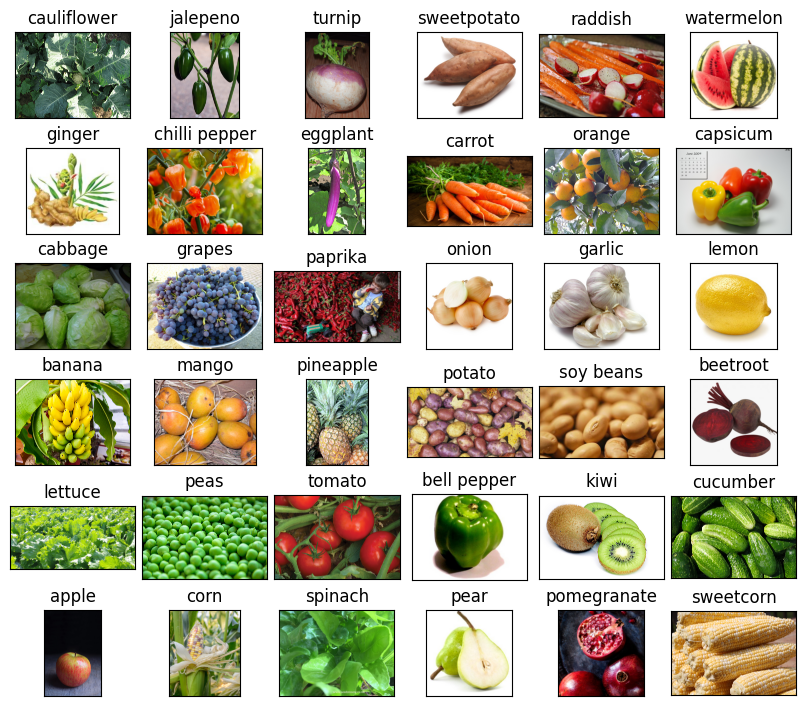

In [15]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [16]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [17]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [18]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [19]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [20]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [21]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10


c:\Users\abdul\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.3664 - loss: 2.4947 - val_accuracy: 0.8324 - val_loss: 0.4925
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8138 - loss: 0.5991 - val_accuracy: 0.9029 - val_loss: 0.2855
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.8955 - loss: 0.3304 - val_accuracy: 0.9353 - val_loss: 0.2655
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9229 - loss: 0.2429 - val_accuracy: 0.9412 - val_loss: 0.1980
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 94s 993ms/step - accuracy: 0.9525 - loss: 0.1483 - val_accuracy: 0.9618 - val_loss: 0.1666
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.9534 - loss: 0.1202 - val_accuracy: 0.9294 - val_loss: 0.2133
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 94s 998ms/step - accuracy: 0.9697 - loss: 0.0999 - val_accuracy: 0.9647 - val_loss: 0.1415
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 94s 993ms/step - accuracy: 0.9871 - loss: 0.0548 - val_accuracy: 0.9588 - val_loss:

In [22]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


['carrot',
 'apple',
 'peas',
 'corn',
 'turnip',
 'spinach',
 'tomato',
 'garlic',
 'banana',
 'pomegranate',
 'jalepeno',
 'cucumber',
 'pear',
 'pomegranate',
 'carrot',
 'eggplant',
 'pineapple',
 'onion',
 'beetroot',
 'apple',
 'turnip',
 'mango',
 'tomato',
 'ginger',
 'tomato',
 'watermelon',
 'jalepeno',
 'lemon',
 'soy beans',
 'watermelon',
 'lettuce',
 'capsicum',
 'cauliflower',
 'grapes',
 'onion',
 'raddish',
 'lemon',
 'eggplant',
 'potato',
 'pomegranate',
 'cauliflower',
 'watermelon',
 'tomato',
 'bell pepper',
 'garlic',
 'spinach',
 'mango',
 'potato',
 'peas',
 'paprika',
 'beetroot',
 'potato',
 'banana',
 'pineapple',
 'apple',
 'lettuce',
 'soy beans',
 'potato',
 'lettuce',
 'spinach',
 'kiwi',
 'pineapple',
 'apple',
 'turnip',
 'raddish',
 'paprika',
 'ginger',
 'onion',
 'corn',
 'turnip',
 'sweetpotato',
 'pear',
 'cabbage',
 'onion',
 'mango',
 'soy beans',
 'capsicum',
 'banana',
 'capsicum',
 'cucumber',
 'jalepeno',
 'capsicum',
 'pomegranate',
 'lemon

In [23]:
from sklearn.metrics import accuracy_score
y_test = [labels[k] for k in test_images.classes]
acc = accuracy_score(y_test, pred1)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 97.35%


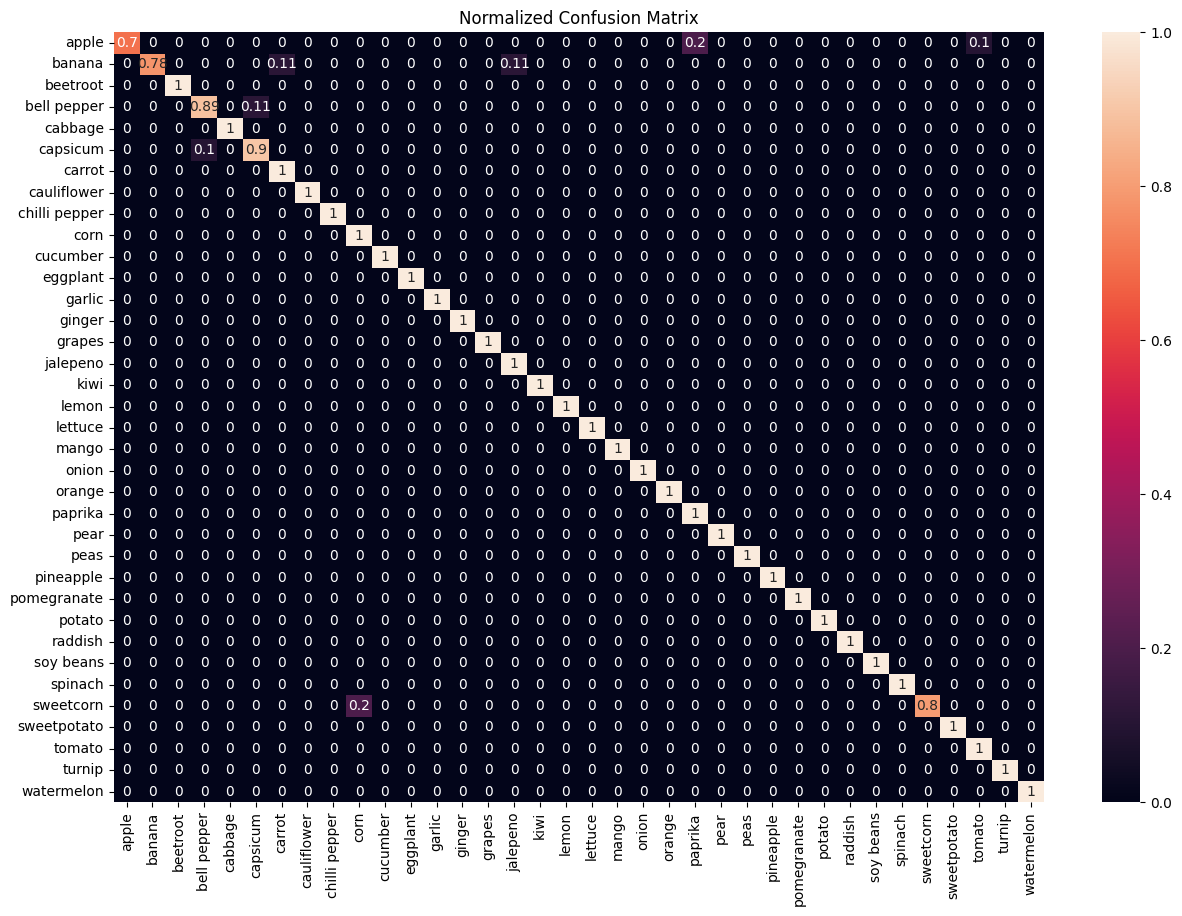

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred1, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

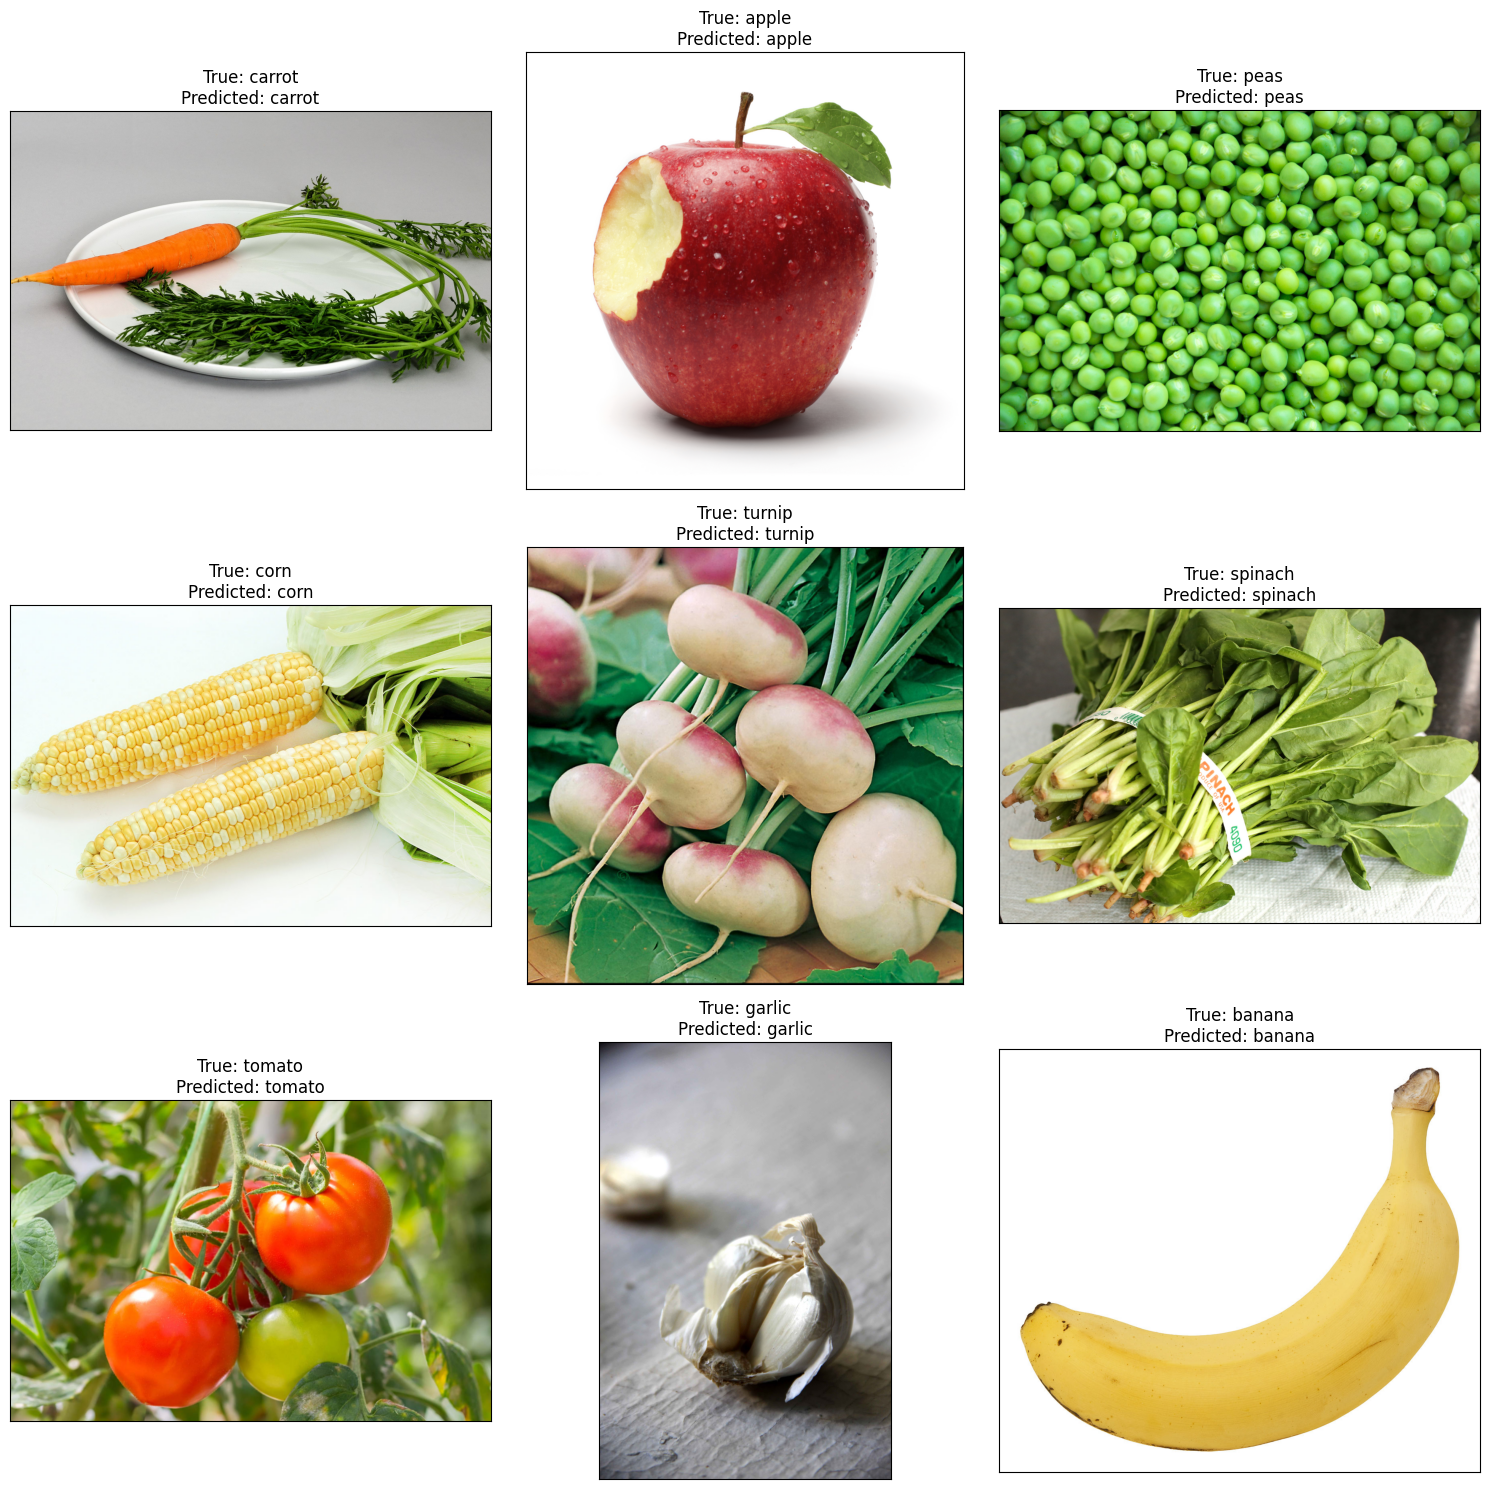

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred1[i]}")
plt.tight_layout()
plt.show()

In [64]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [65]:
img = output('C:/Users/abdul/OneDrive/Desktop/Image-recognition/apple-fir.png')
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


'apple'

In [60]:
img = output('C:/Users/abdul/OneDrive/Desktop/Image-recognition/spinach-fir.jpeg')
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


'spinach'

In [66]:

img = output("c:/Users/abdul/OneDrive/Desktop/Image-recognition/uploads/itu epic weapon.jpg")
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


'beetroot'

In [38]:
from tensorflow.keras.models import load_model

# Assuming you have already trained your model and it is stored in the variable 'model'
model.save('model.h5')
